In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import importlib
import scalesc as ssc

/edgehpc/dept/compbio/users/hzhang13/envs/scalesc2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data_dir = '../data_dir/1.7M_human_brain_ROSMAP/'

scalesc = ssc.ScaleSC(data_dir=data_dir, 
                  max_cell_batch=1e5, # no more than 1e5 is suggested
                  preload_on_cpu=True, 
                  preload_on_gpu=True, 
                  save_raw_counts=False,
                  save_norm_counts=False,
                  output_dir='test_scalesc_1.7M_results')

In [6]:
# calculate qc if qc hasn't been performed 
scalesc.calculate_qc_metrics()
print(scalesc.adata.shape)

(1681258, 32102)


In [7]:
# filer cells and genes
scalesc.filter_genes(min_count=3)
scalesc.filter_cells(min_count=200, max_count=6000)
print('shape after filtering', scalesc.adata.shape)

shape after filtering (1412491, 32102)


In [8]:
# hvg
scalesc.highly_variable_genes(n_top_genes=4000)
scalesc.adata.var[scalesc.adata.var['highly_variable'] == True]

,highly_variable
HES5,True
TTC34,True
AC242022.2,True
PRDM16-DT,True
PRDM16,True
...,...
TTTY9B,True
TTTY14,True
TTTY10,True
AC010086.3,True


In [9]:
# normal and log1p 
scalesc.normalize_log1p()

In [10]:
# pca use hvg
scalesc.pca(n_components=50, hvg_var='highly_variable')
print(scalesc.adata[sorted(scalesc.adata.obs_names)].obsm['X_pca'])

[[-9.05439933e+00  1.74787916e+01 -3.09010989e+00 ... -3.93096293e-02
  -5.92239577e-01 -5.79724847e-02]
 [ 7.79819068e+00 -1.43952020e+00  8.71067357e-01 ... -5.48653707e-01
  -4.36776068e-01  4.84731307e-01]
 [-1.09341786e+01  1.95978958e+01 -2.56666153e+00 ...  1.12767835e+00
  -9.02318970e-01  1.88064921e-01]
 ...
 [-1.28630820e+01 -1.04625826e+01 -4.80943228e+00 ... -1.48709269e+00
  -1.07830110e+00 -2.35686083e-01]
 [ 1.99850282e+01 -2.58058687e+00 -1.92519811e+00 ... -1.05671265e-03
  -5.82620802e-01 -5.26507829e-01]
 [-1.08248738e+01  1.90194263e+01 -2.57035860e+00 ...  1.30423164e+00
   3.76610475e-02 -1.68299565e+00]]


In [11]:
# harmony
scalesc.harmony(sample_col_name='sampleID', max_iter_harmony=10)

2024-11-03 21:56:41,874 - scaleSC - DEBUG - Harmony: Iteration 1 of 10
2024-11-03 21:57:11,626 - scaleSC - DEBUG - Harmony: Iteration 2 of 10
2024-11-03 21:57:41,149 - scaleSC - DEBUG - Harmony: Iteration 3 of 10
2024-11-03 21:58:10,785 - scaleSC - DEBUG - Harmony: Iteration 4 of 10
2024-11-03 21:58:30,780 - scaleSC - DEBUG - Harmony: Iteration 5 of 10
2024-11-03 21:58:45,604 - scaleSC - DEBUG - Harmony: Iteration 6 of 10
2024-11-03 21:58:59,836 - scaleSC - DEBUG - Harmony: Iteration 7 of 10
2024-11-03 21:59:14,076 - scaleSC - DEBUG - Harmony: Iteration 8 of 10
2024-11-03 21:59:28,199 - scaleSC - DEBUG - Harmony: Iteration 9 of 10
2024-11-03 21:59:58,680 - scaleSC - DEBUG - Harmony: Iteration 10 of 10
2024-11-03 22:00:12,920 - scaleSC - INFO - Harmony: Converged after 10 iterations


In [12]:
# neighbors & leiden & umap
scalesc.neighbors(n_neighbors=20, n_pcs=50, use_rep='X_pca_harmony')
scalesc.leiden(resolution=0.1)
scalesc.umap()

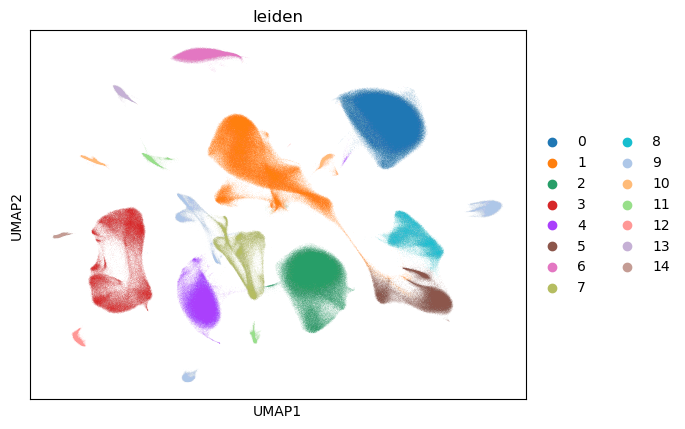

In [61]:
# plot umap
sc.pl.umap(scalesc.adata, color='leiden')

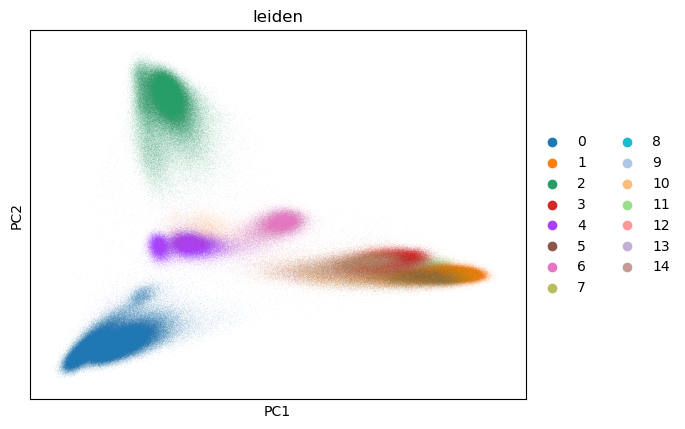

In [62]:
# plot pca
sc.pl.pca(scalesc.adata, color='leiden')

In [63]:
# save adata to disk, note: this adata doesn't contain count matrix 
scalesc.save()

In [64]:
# save normalized count matrix to disk in batches
scalesc.savex(name='norm_counts')

In [65]:
# get merged adata with count matrix, but have to perform it on CPU
scalesc.to_CPU()
adata = scalesc.adata_X
adata.obs['leiden'] = scalesc.adata.obs['leiden']
adata.obsm['X_umap'] = scalesc.adata.obsm['X_umap']

In [66]:
# find marker and refine clusters
cluster_col_after_merge = ssc.adata_cluster_merge(adata, 'leiden')

2024-11-04 09:04:05,447 - scaleSC - DEBUG - Preparing data...
2024-11-04 09:04:05,464 - scaleSC - DEBUG - n_total_clusters: 15
2024-11-04 09:04:05,465 - scaleSC - DEBUG - 0.016798019409179688 seconds
2024-11-04 09:04:05,465 - scaleSC - DEBUG - Calculating medians...
2024-11-04 09:05:24,932 - scaleSC - DEBUG - Time - calculate_median_sparse_fast_gpu: 79.46694898605347s
2024-11-04 09:05:24,933 - scaleSC - DEBUG - 79.46788191795349 seconds
2024-11-04 09:05:24,934 - scaleSC - DEBUG - Number of clusters to evaluate: 15
2024-11-04 09:05:50,642 - scaleSC - DEBUG - 1 out of 15:
2024-11-04 09:05:50,643 - scaleSC - DEBUG - 	0
2024-11-04 09:07:18,036 - scaleSC - DEBUG - Time - myXGBClassifier: 87.39283037185669s
2024-11-04 09:07:31,678 - scaleSC - DEBUG - Time - myDecisionTreeEvaluation: 13.629095315933228s
2024-11-04 09:07:31,678 - scaleSC - DEBUG - 	['ST18', 'PLP1', 'RNF220', 'LINC01608', 'HHIP', 'MOBP', 'CNP', 'SLC7A14-AS1', 'CNDP1', 'FAM107B', 'AC008571.2', 'SLCO1A2', 'PXK', 'CLMN', 'POLR2F',

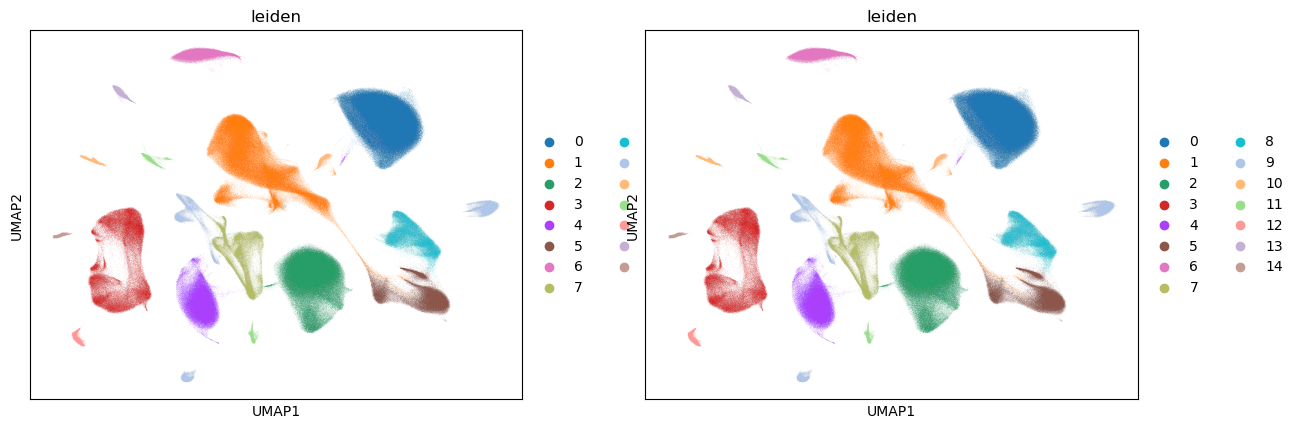

In [67]:
sc.pl.umap(adata, color=['leiden', cluster_col_after_merge])

In [68]:
# use another dataset to test
fname = '/edgehpc/dept/compbio/projects/scaleSC/data/marker_merge/TB_harmony.h5ad'
adata_TB = sc.read_h5ad(fname)
cluster_col_after_merge_TB = ssc.adata_cluster_merge(adata_TB, 'TB.leiden_res.1')

2024-11-04 09:34:58,308 - scaleSC - DEBUG - Preparing data...
2024-11-04 09:34:58,309 - scaleSC - DEBUG - n_total_clusters: 15
2024-11-04 09:34:58,310 - scaleSC - DEBUG - 0.0012178421020507812 seconds
2024-11-04 09:34:58,310 - scaleSC - DEBUG - Calculating medians...
2024-11-04 09:35:00,756 - scaleSC - DEBUG - Time - calculate_median_sparse_fast_gpu: 2.445831537246704s
2024-11-04 09:35:00,757 - scaleSC - DEBUG - 2.4464609622955322 seconds
2024-11-04 09:35:00,757 - scaleSC - DEBUG - Number of clusters to evaluate: 15
2024-11-04 09:35:00,954 - scaleSC - DEBUG - 1 out of 15:
2024-11-04 09:35:00,955 - scaleSC - DEBUG - 	0
2024-11-04 09:35:04,067 - scaleSC - DEBUG - Time - myXGBClassifier: 3.112135887145996s
2024-11-04 09:35:04,431 - scaleSC - DEBUG - Time - myDecisionTreeEvaluation: 0.3515009880065918s
2024-11-04 09:35:04,431 - scaleSC - DEBUG - 	['ATP10A', 'ARHGEF12', 'UBL3', 'GPR155', 'CD8B', 'ITGA1', 'CD8A', 'NFIA', 'CD226', 'RASGRF2', 'GALNT10', 'MYBL1', 'RUNX2', 'PRKCA', 'IL7R', 'MNAT

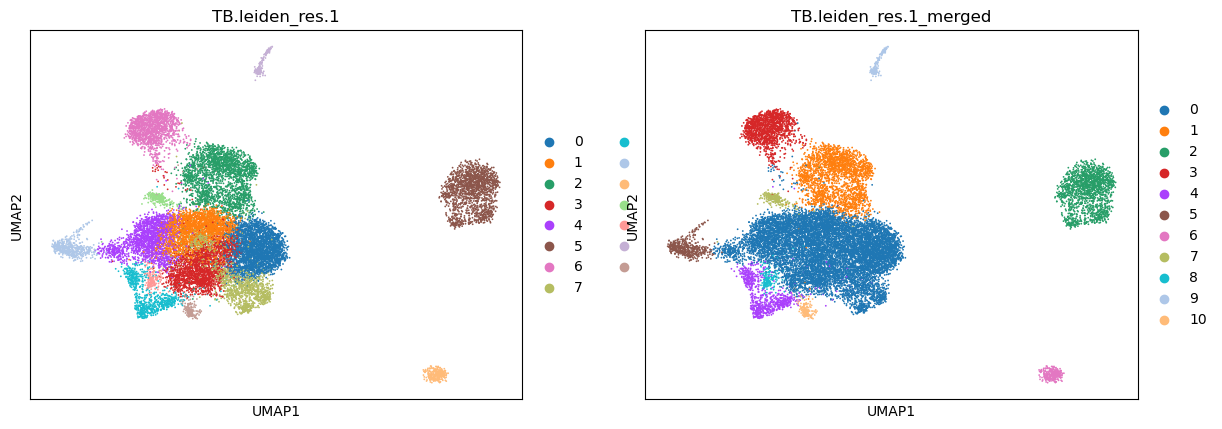

In [70]:
sc.pl.umap(adata_TB, color=['TB.leiden_res.1', cluster_col_after_merge_TB])